In [1]:
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as T
import torch
import torch.nn as nn
import os
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.io import read_image
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

#import time
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns


### Loading and visualizing the data 

In [2]:
#file paths

path = "Assignment 1 - Semantic Segmentation - Dataset/train_val"
img_path = path + "/images/"
mask_path = path + "/masks/"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# torch.cuda.set_device(device+':0')

Using cuda device


In [4]:
#class to load dataset

class Dataset(Dataset):
    #'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs,img_transform = None,mask_transform = None):
        'Initialization'
        self.list_IDs = list_IDs
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __len__(self):
        #'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        #'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]

        # Load data and get label
        X = torch.from_numpy(plt.imread(img_path + ID + '.jpg'))
        y = torch.from_numpy(plt.imread(mask_path + ID + '.bmp'))
          
        if self.img_transform:
            X = X.permute(2,0,1)    #changing channels to first axis
            X = self.img_transform(X)
        if self.mask_transform:
            y = y.permute(2,0,1)
            y = self.mask_transform(y)

        return X, y

In [5]:
list_ids = [id.split('.jpg')[0] for id in os.listdir(img_path)]       #list image names

data = Dataset(list_ids)

d_r_37_


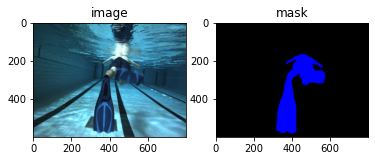

w_r_51_


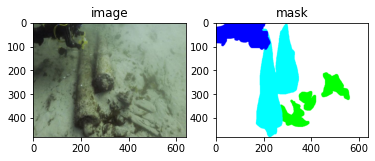

f_r_1696_


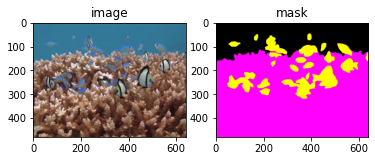

f_r_1990_


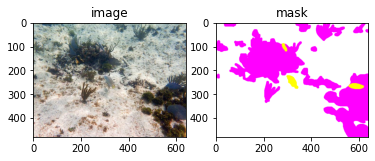

d_r_31_


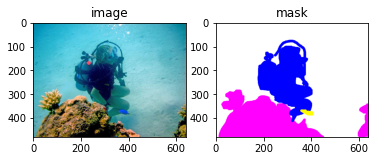

In [6]:
for i in random.sample(range(len(list_ids)),5):
    X,y = data.__getitem__(i)
    print(list_ids[i])
    plt.subplot(1,2,1)
    plt.imshow(X)
    plt.title('image')
    plt.subplot(1,2,2)
    plt.imshow(y)
    plt.title('mask')
    plt.show()

### Data Preprocessing

In [7]:
class mask_channel:
#     def __init__(self):
#         pass
    
    def __call__(self, image_rgb):
        
        image_rgb = image_rgb.permute(1,2,0)                 #channel dimension last axis
        image_rgb = image_rgb.detach().numpy()
 
        lower_cyan = (0,235,235)
        upper_cyan = (10,255,255)
        mask_cyan = cv2.inRange(image_rgb, lower_cyan,upper_cyan)

        lower_blue = (0,0,200)
        upper_blue = (20,20,255)
        mask_blue = cv2.inRange(image_rgb, lower_blue,upper_blue)

        lower_black = (0,0,0)
        upper_black = (20,20,20)
        mask_black = cv2.inRange(image_rgb, lower_black,upper_black)

        lower_white = (235,235,235)
        upper_white = (255,255,255)
        mask_white = cv2.inRange(image_rgb, lower_white,upper_white)

        lower_pink = (235,0,235)
        upper_pink = (255,10,255)
        mask_pink = cv2.inRange(image_rgb, lower_pink,upper_pink)

        lower_red = (235,0,0)
        upper_red = (255,20,20)
        mask_red = cv2.inRange(image_rgb, lower_red,upper_red)

        lower_yellow = (235,235,0)
        upper_yellow = (255,255,20)
        mask_yellow = cv2.inRange(image_rgb, lower_yellow,upper_yellow)

        lower_green = (0,235,0)
        upper_green = (20,255,20)
        mask_green = cv2.inRange(image_rgb, lower_green,upper_green)
        
        y = np.stack([mask_white,mask_black,mask_cyan,mask_blue,mask_pink,mask_red,mask_yellow,mask_green])
        
        return y

In [8]:
img_tfrm =  transforms.Compose([transforms.Grayscale(1),transforms.CenterCrop(572)])
mask_tfrm = transforms.Compose([transforms.Resize((388,388)),mask_channel()])

data = Dataset(list_ids,img_tfrm,mask_tfrm)


In [9]:
BATCH_SIZE = 1
# dataset_loader = DataLoader(data,batch_size=BATCH_SIZE, shuffle=True,num_workers=0)

total_len = data.__len__()
train_len = int(total_len*0.8)
test_len = total_len - train_len

train,test = random_split(data,(train_len,test_len))

train_loader = DataLoader(train,batch_size=BATCH_SIZE, shuffle=True,num_workers=0)
test_loader = DataLoader(test,batch_size=BATCH_SIZE, shuffle=True,num_workers=0)

In [10]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([1, 1, 572, 572])
Labels batch shape: torch.Size([1, 8, 388, 388])


In [11]:
#double 3x3 convolution 
def dual_conv(in_channel, out_channel):
    conv = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3),
        nn.ReLU(inplace= True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3),
        nn.ReLU(inplace= True),
    )
    return conv


# crop the image(tensor) to equal size 
# as shown in architecture image , half left side image is concated with right side image
def crop_tensor(target_tensor, tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2

    return tensor[:, :, delta:tensor_size- delta, delta:tensor_size-delta]

class Unet(nn.Module):
    def __init__(self):
        super(Unet, self).__init__()

        # Left side (contracting path)
        self.dwn_conv1 = dual_conv(1, 64)
        self.dwn_conv2 = dual_conv(64, 128)
        self.dwn_conv3 = dual_conv(128, 256)
        self.dwn_conv4 = dual_conv(256, 512)
        self.dwn_conv5 = dual_conv(512, 1024)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Right side  (expnsion path) 
        #transpose convolution is used showna as green arrow in architecture image
        self.trans1 = nn.ConvTranspose2d(1024,512, kernel_size=2, stride= 2)
        self.up_conv1 = dual_conv(1024,512)
        self.trans2 = nn.ConvTranspose2d(512,256, kernel_size=2, stride= 2)
        self.up_conv2 = dual_conv(512,256)
        self.trans3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride= 2)
        self.up_conv3 = dual_conv(256,128)
        self.trans4 = nn.ConvTranspose2d(128,64, kernel_size=2, stride= 2)
        self.up_conv4 = dual_conv(128,64)

        #output layer
        self.out = nn.Conv2d(64, 8, kernel_size=1)

    def forward(self, image):

        #forward pass for Left side
        x1 = self.dwn_conv1(image)
        x2 = self.maxpool(x1)
        x3 = self.dwn_conv2(x2)
        x4 = self.maxpool(x3)
        x5 = self.dwn_conv3(x4)
        x6 = self.maxpool(x5)
        x7 = self.dwn_conv4(x6)
        x8 = self.maxpool(x7)
        x9 = self.dwn_conv5(x8)
        

        #forward pass for Right side
        x = self.trans1(x9)
        y = crop_tensor(x, x7)
        x = self.up_conv1(torch.cat([x,y], 1))

        x = self.trans2(x)
        y = crop_tensor(x, x5)
        x = self.up_conv2(torch.cat([x,y], 1))

        x = self.trans3(x)
        y = crop_tensor(x, x3)
        x = self.up_conv3(torch.cat([x,y], 1))

        x = self.trans4(x)
        y = crop_tensor(x, x1)
        x = self.up_conv4(torch.cat([x,y], 1))
        
        x = self.out(x)
        
        return x

In [30]:
model = Unet().to(device)
print(model)
# model = Unet()

Unet(
  (dwn_conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dwn_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dwn_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dwn_conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dwn_conv5): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(1024, 1024, kernel_size=(3, 3),

In [34]:
X,y = iter(train_loader).next()
X = X.to(torch.device('cuda'))
y = y.to(torch.device('cuda'))

pp = model(X/255)

RuntimeError: CUDA out of memory. Tried to allocate 80.00 MiB (GPU 0; 4.00 GiB total capacity; 2.52 GiB already allocated; 0 bytes free; 2.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [28]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)

writer = SummaryWriter()

def train_loop(dataloader, model, loss_fn, optimizer,epoch=1):
    size = len(dataloader.dataset)
    for e in range(epoch):
        for batch, (X, y) in enumerate(dataloader):
            # Compute prediction and loss\
            X = X.to(torch.device('cuda'))
            y = y.to(torch.device('cuda'))

            pred = model(X/255)
            loss = loss_fn(pred, y/255)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
                


In [63]:
train_loop(train_loader,model,loss_fn,optimizer)

<class 'torch.Tensor'>
loss: 2.017856  [    0/ 1220]
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<cla

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


KeyboardInterrupt: 